# **Advancements in glioma segmentation: comparing U-Net and DeconvNet**
This Colab notebook demonstrates the process of building and training a U-Net model for brain tumor segmentation. The dataset utilized is the BraTS 2018 dataset, and the notebook covers steps such as data loading, preprocessing, model definition, training, and evaluation. The primary goal of this notebook is to provide a comprehensive guide to developing a deep learning solution for medical image segmentation.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import numpy as np
from PIL import Image
import tensorflow as tf
from scipy import stats
from pathlib import Path
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [ ]:
data_path = '/content/drive/MyDrive/Veritas AI/Veritas AI - Amaan/data/BraTS 2018'

train_data_path = os.path.join(data_path, 'train')
val_data_path = os.path.join(data_path, 'val')

train_images_path = os.path.join(train_data_path, 'images')
train_masks_path = os.path.join(train_data_path, 'masks')

val_images_path = os.path.join(val_data_path, 'images')
val_masks_path = os.path.join(val_data_path, 'masks')

train_images_list = os.listdir(train_images_path)
train_masks_list  = os.listdir(train_masks_path)
train_images_list.sort()
train_masks_list.sort()

val_images_list = os.listdir(val_images_path)
val_masks_list  = os.listdir(val_masks_path)
val_images_list.sort()
val_masks_list.sort()

In [ ]:
X_train = np.zeros((len(train_images_list), 128, 128, 1))
Y_train = np.zeros((len(train_images_list), 128, 128))


for i in range(len(train_images_list)):
  mask = Image.open(os.path.join(train_masks_path, train_masks_list[i]))
  image = Image.open(os.path.join(train_images_path, train_images_list[i]))
  resized_image = image.resize((128, 128), resample=Image.BILINEAR)
  resized_mask = mask.resize((128, 128), resample=Image.NEAREST)
  resized_image = np.array(resized_image) / 255
  resized_mask = np.array(resized_mask) / 50
  X_train[i, :, :, 0] = resized_image
  Y_train[i, :, :] = resized_mask

np.save('/content/drive/MyDrive/Veritas AI/Veritas AI - Amaan/data/X_train.npy', X_train)
np.save('/content/drive/MyDrive/Veritas AI/Veritas AI - Amaan/data/Y_train.npy', Y_train)

In [ ]:
X_val = np.zeros((len(val_images_list), 128, 128, 1))
Y_val = np.zeros((len(val_images_list), 128, 128))


for i in range(len(val_images_list)):
  mask = Image.open(os.path.join(val_masks_path, val_masks_list[i]))
  image = Image.open(os.path.join(val_images_path, val_images_list[i]))
  resized_image = image.resize((128, 128),resample = Image.BILINEAR)
  resized_mask = mask.resize((128,128),resample = Image.NEAREST)
  resized_image = np.array(resized_image) / 255
  resized_mask = np.array(resized_mask) / 50
  X_val[i,:, :, 0] = resized_image
  Y_val[i,:, :] = resized_mask

np.save('/content/drive/MyDrive/Veritas AI/Veritas AI - Amaan/data/X_val.npy', X_val)
np.save('/content/drive/MyDrive/Veritas AI/Veritas AI - Amaan/data/Y_val.npy', Y_val)

In [ ]:
X_train = np.load('/content/drive/MyDrive/Veritas AI/Veritas AI - Amaan/data/X_train.npy')
Y_train = np.load('/content/drive/MyDrive/Veritas AI/Veritas AI - Amaan/data/Y_train.npy')
X_val = np.load('/content/drive/MyDrive/Veritas AI/Veritas AI - Amaan/data/X_val.npy')
Y_val = np.load('/content/drive/MyDrive/Veritas AI/Veritas AI - Amaan/data/Y_val.npy')

In [ ]:
Y_train = (Y_train >= 1).astype('int')
Y_val = (Y_val >= 1).astype('int')

Y_train = np.eye(2)[Y_train]
Y_val = np.eye(2)[Y_val]

In [ ]:
def create_baseline_model():
  # Encoder-decoder
  # input
  input_layer = tf.keras.layers.Input(shape=(128, 128, 1))
  # encoder path
  # 1st level
  x = tf.keras.layers.Conv2D(32, 3, activation = 'relu', padding = 'same')(input_layer)
  x = tf.keras.layers.Conv2D(32, 3, activation = 'relu', padding = 'same')(x)
  x = tf.keras.layers.Dropout(0.15)(x)
  x = tf.keras.layers.MaxPooling2D()(x)
  # 2nd level
  x = tf.keras.layers.Conv2D(64, 3, activation = 'relu', padding = 'same')(x)
  x = tf.keras.layers.Conv2D(64, 3, activation = 'relu', padding = 'same')(x)
  x = tf.keras.layers.Dropout(0.15)(x)
  x = tf.keras.layers.MaxPooling2D()(x)
  # 3rd level
  x = tf.keras.layers.Conv2D(128, 3, activation = 'relu', padding = 'same')(x)
  x = tf.keras.layers.Conv2D(128, 3, activation = 'relu', padding = 'same')(x)
  x = tf.keras.layers.Dropout(0.15)(x)
  x = tf.keras.layers.MaxPooling2D()(x)
  # 4th level
  x = tf.keras.layers.Conv2D(256, 3, activation = 'relu', padding = 'same')(x)
  x = tf.keras.layers.Conv2D(256, 3, activation = 'relu', padding = 'same')(x)
  x = tf.keras.layers.Dropout(0.15)(x)
  x = tf.keras.layers.MaxPooling2D()(x)
  # decoder path
  # bottleneck
  x = tf.keras.layers.Conv2D(512, 3, activation = 'relu', padding = 'same')(x)
  x = tf.keras.layers.Conv2D(512, 3, activation = 'relu', padding = 'same')(x)
  x = tf.keras.layers.Dropout(0.15)(x)
  x = tf.keras.layers.Conv2DTranspose(256, 2, strides = (2,2), activation = 'relu', padding = 'same')(x)
  # 4th level
  x = tf.keras.layers.Conv2D(256, 3, activation = 'relu', padding = 'same')(x)
  x = tf.keras.layers.Conv2D(256, 3, activation = 'relu', padding = 'same')(x)
  x = tf.keras.layers.Dropout(0.15)(x)
  x = tf.keras.layers.Conv2DTranspose(128, 2, strides = (2, 2), activation = 'relu', padding = 'same')(x)
  # 3rd level
  x = tf.keras.layers.Conv2D(128, 3, activation = 'relu', padding = 'same')(x)
  x = tf.keras.layers.Conv2D(128, 3, activation = 'relu', padding = 'same')(x)
  x = tf.keras.layers.Dropout(0.15)(x)
  x = tf.keras.layers.Conv2DTranspose(64, 2, strides = (2, 2), activation = 'relu', padding = 'same')(x)
  # 2nd level
  x = tf.keras.layers.Conv2D(64, 3, activation = 'relu', padding = 'same')(x)
  x = tf.keras.layers.Conv2D(64, 3, activation = 'relu', padding = 'same')(x)
  x = tf.keras.layers.Dropout(0.15)(x)
  x = tf.keras.layers.Conv2DTranspose(32, 2, strides = (2, 2), activation = 'relu', padding = 'same')(x)
  # 1st level
  x = tf.keras.layers.Conv2D(32, 3, activation = 'relu', padding = 'same')(x)
  x = tf.keras.layers.Conv2D(32, 3, activation = 'relu', padding = 'same')(x)
  x = tf.keras.layers.Dropout(0.15)(x)
  # output
  output_layer = tf.keras.layers.Conv2D(2, 1, activation = 'softmax')(x)
  # build model
  baseline_model = tf.keras.models.Model(inputs = input_layer, outputs = output_layer)
  return baseline_model

In [ ]:
def dice_accuracy(y_true, y_pred, epsilon=1e-7):
  num_classes = y_true.shape[-1]
  y_true = tf.cast(y_true, tf.float32)
  y_pred_class = tf.one_hot(tf.argmax(y_pred, axis=-1), num_classes)
  y_true = y_true[..., 1:] # excluding background
  y_pred_class = y_pred_class[..., 1:] # excluding background
  intersection = tf.reduce_sum(y_true * y_pred_class, axis=[1, 2])
  union = tf.reduce_sum(y_true, axis=[1, 2]) + tf.reduce_sum(y_pred_class, axis=[1, 2])
  dice_scores = (2 * intersection + epsilon) / (union + epsilon)
  mean_dice = tf.reduce_mean(dice_scores)
  return mean_dice

In [ ]:
baseline_model = create_baseline_model()
baseline_model.compile(optimizer = tf.keras.optimizers.Adam(), loss = tf.keras.losses.CategoricalCrossentropy(), metrics = [dice_accuracy])
baseline_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 1)]     0         
                                                                 
 conv2d (Conv2D)             (None, 128, 128, 32)      320       
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 32)      9248      
                                                                 
 dropout (Dropout)           (None, 128, 128, 32)      0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 64, 64, 32)        0         
 D)                                                              
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 64, 64)        18496     
                                                             

In [ ]:
weights_path = '/content/drive/MyDrive/Veritas AI/Veritas AI - Amaan/weights/encoder-decoder'

In [ ]:
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    monitor='val_dice_accuracy',
    filepath=os.path.join(weights_path, '{epoch:03d}-{val_dice_accuracy:.4f}.h5'),
    verbose=1,
    save_weights_only=True,
    save_best_only=True,
    mode='max')

baseline_history = baseline_model.fit(X_train, Y_train, validation_data = (X_val, Y_val), epochs = 30, batch_size = 16, callbacks=[checkpoint])

Epoch 1/30
235/235 [==============================] - ETA: 0s - loss: 0.1624 - dice_accuracy: 0.2840
Epoch 1: val_dice_accuracy improved from -inf to 0.79237, saving model to /content/drive/MyDrive/Veritas AI/Veritas AI - Amaan/weights/encoder-decoder/001-0.7924.h5
235/235 [==============================] - 49s 131ms/step - loss: 0.1624 - dice_accuracy: 0.2840 - val_loss: 0.0543 - val_dice_accuracy: 0.7924
Epoch 2/30
235/235 [==============================] - ETA: 0s - loss: 0.0478 - dice_accuracy: 0.8124
Epoch 2: val_dice_accuracy improved from 0.79237 to 0.81565, saving model to /content/drive/MyDrive/Veritas AI/Veritas AI - Amaan/weights/encoder-decoder/002-0.8157.h5
235/235 [==============================] - 22s 94ms/step - loss: 0.0478 - dice_accuracy: 0.8124 - val_loss: 0.0499 - val_dice_accuracy: 0.8157
Epoch 3/30
235/235 [==============================] - ETA: 0s - loss: 0.0403 - dice_accuracy: 0.8428
Epoch 3: val_dice_accuracy improved from 0.81565 to 0.82483, saving model to 

In [ ]:
weights_list = os.listdir(weights_path)
weights_list.sort()
baseline_model.load_weights(os.path.join(weights_path, weights_list[-1]))

In [ ]:
def create_unet_model():
  # U-Net
  # input
  input_layer = tf.keras.layers.Input(shape=(128, 128, 1))
  # encoder path
  # 1st level
  x = tf.keras.layers.Conv2D(32, 3, activation = 'relu', padding = 'same')(input_layer)
  x = tf.keras.layers.Conv2D(32, 3, activation = 'relu', padding = 'same')(x)
  skip_1 = x
  x = tf.keras.layers.Dropout(0.15)(x)
  x = tf.keras.layers.MaxPooling2D()(x)
  # 2nd level
  x = tf.keras.layers.Conv2D(64, 3, activation = 'relu', padding = 'same')(x)
  x = tf.keras.layers.Conv2D(64, 3, activation = 'relu', padding = 'same')(x)
  skip_2 = x
  x = tf.keras.layers.Dropout(0.15)(x)
  x = tf.keras.layers.MaxPooling2D()(x)
  # 3rd level
  x = tf.keras.layers.Conv2D(128, 3, activation = 'relu', padding = 'same')(x)
  x = tf.keras.layers.Conv2D(128, 3, activation = 'relu', padding = 'same')(x)
  skip_3 = x
  x = tf.keras.layers.Dropout(0.15)(x)
  x = tf.keras.layers.MaxPooling2D()(x)
  # 4th level
  x = tf.keras.layers.Conv2D(256, 3, activation = 'relu', padding = 'same')(x)
  x = tf.keras.layers.Conv2D(256, 3, activation = 'relu', padding = 'same')(x)
  skip_4 = x
  x = tf.keras.layers.Dropout(0.15)(x)
  x = tf.keras.layers.MaxPooling2D()(x)
  # decoder path
  # bottleneck
  x = tf.keras.layers.Conv2D(512, 3, activation = 'relu', padding = 'same')(x)
  x = tf.keras.layers.Conv2D(512, 3, activation = 'relu', padding = 'same')(x)
  x = tf.keras.layers.Dropout(0.15)(x)
  x = tf.keras.layers.Conv2DTranspose(256, 2, strides = (2,2), activation = 'relu', padding = 'same')(x)
  # 4th level
  x = tf.keras.layers.concatenate([x, skip_4])
  x = tf.keras.layers.Conv2D(256, 3, activation = 'relu', padding = 'same')(x)
  x = tf.keras.layers.Conv2D(256, 3, activation = 'relu', padding = 'same')(x)
  x = tf.keras.layers.Dropout(0.15)(x)
  x = tf.keras.layers.Conv2DTranspose(128, 2, strides = (2,2), activation = 'relu', padding = 'same')(x)
  # 3rd level
  x = tf.keras.layers.concatenate([x, skip_3])
  x = tf.keras.layers.Conv2D(128, 3, activation = 'relu', padding = 'same')(x)
  x = tf.keras.layers.Conv2D(128, 3, activation = 'relu', padding = 'same')(x)
  x = tf.keras.layers.Dropout(0.15)(x)
  x = tf.keras.layers.Conv2DTranspose(64, 2, strides = (2,2), activation = 'relu', padding = 'same')(x)
  # 2nd level
  x = tf.keras.layers.concatenate([x, skip_2])
  x = tf.keras.layers.Conv2D(64, 3, activation = 'relu', padding = 'same')(x)
  x = tf.keras.layers.Conv2D(64, 3, activation = 'relu', padding = 'same')(x)
  x = tf.keras.layers.Dropout(0.15)(x)
  x = tf.keras.layers.Conv2DTranspose(32, 2, strides = (2,2), activation = 'relu', padding = 'same')(x)
  # 1st level
  x = tf.keras.layers.concatenate([x, skip_1])
  x = tf.keras.layers.Conv2D(32, 3, activation = 'relu', padding = 'same')(x)
  x = tf.keras.layers.Conv2D(32, 3, activation = 'relu', padding = 'same')(x)
  x = tf.keras.layers.Dropout(0.15)(x)
  # output
  output_layer = tf.keras.layers.Conv2D(2, 1, activation = 'softmax')(x)
  # build model
  unet_model = tf.keras.models.Model(inputs = input_layer, outputs = output_layer)
  return unet_model

In [ ]:
unet_model = create_unet_model()
unet_model.compile(optimizer = tf.keras.optimizers.Adam(), loss = tf.keras.losses.CategoricalCrossentropy(), metrics = [dice_accuracy])
unet_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 128, 128, 1)]        0         []                            
                                                                                                  
 conv2d_19 (Conv2D)          (None, 128, 128, 32)         320       ['input_2[0][0]']             
                                                                                                  
 conv2d_20 (Conv2D)          (None, 128, 128, 32)         9248      ['conv2d_19[0][0]']           
                                                                                                  
 dropout_9 (Dropout)         (None, 128, 128, 32)         0         ['conv2d_20[0][0]']           
                                                                                            

In [ ]:
unet_weights_path = '/content/drive/MyDrive/Veritas AI/Veritas AI - Amaan/weights/U-Net'

In [ ]:
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    monitor='val_dice_accuracy',
    filepath=os.path.join(unet_weights_path, '{epoch:03d}-{val_dice_accuracy:.4f}.h5'),
    verbose=1,
    save_weights_only=True,
    save_best_only=True,
    mode='max')

unet_history = unet_model.fit(X_train, Y_train, validation_data = (X_val, Y_val), epochs = 30, batch_size = 16, callbacks=[checkpoint])

Epoch 1/30
235/235 [==============================] - ETA: 0s - loss: 0.1233 - dice_accuracy: 0.4440
Epoch 1: val_dice_accuracy improved from -inf to 0.72041, saving model to /content/drive/MyDrive/Veritas AI/Veritas AI - Amaan/weights/encoder-decoder/001-0.7204.h5
235/235 [==============================] - 38s 123ms/step - loss: 0.1233 - dice_accuracy: 0.4440 - val_loss: 0.0849 - val_dice_accuracy: 0.7204
Epoch 2/30
235/235 [==============================] - ETA: 0s - loss: 0.0681 - dice_accuracy: 0.7086
Epoch 2: val_dice_accuracy improved from 0.72041 to 0.73702, saving model to /content/drive/MyDrive/Veritas AI/Veritas AI - Amaan/weights/encoder-decoder/002-0.7370.h5
235/235 [==============================] - 24s 104ms/step - loss: 0.0681 - dice_accuracy: 0.7086 - val_loss: 0.0643 - val_dice_accuracy: 0.7370
Epoch 3/30
235/235 [==============================] - ETA: 0s - loss: 0.0606 - dice_accuracy: 0.7421
Epoch 3: val_dice_accuracy did not improve from 0.73702
235/235 [===========

In [ ]:
unet_weights_list = os.listdir(unet_weights_path)
unet_weights_list.sort()
unet_model.load_weights(os.path.join(unet_weights_path, unet_weights_list[-1]))

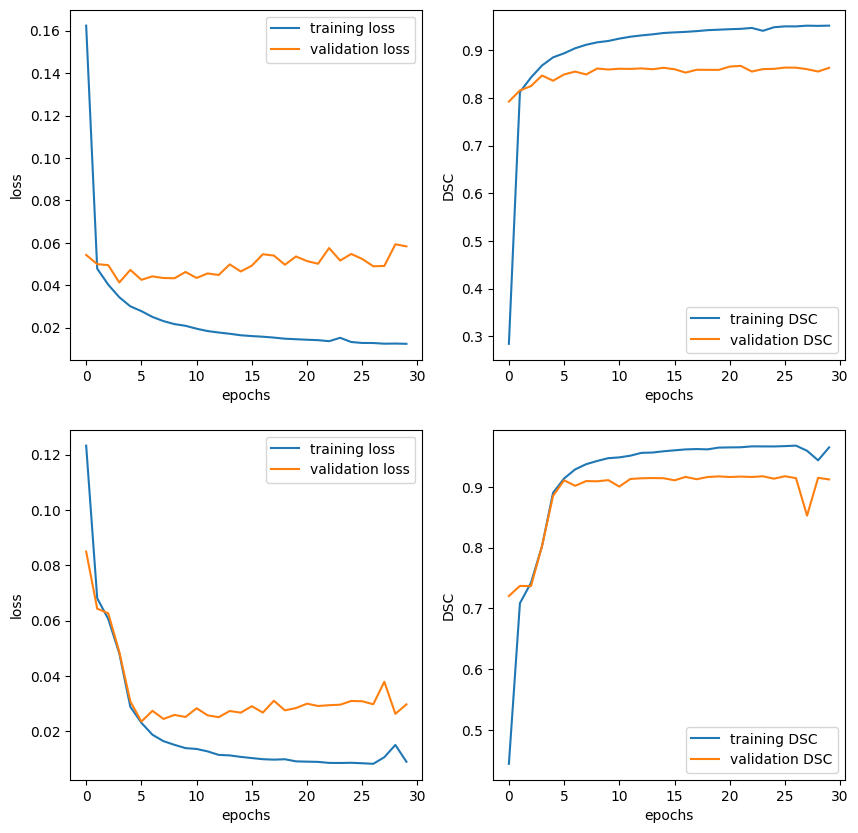

In [ ]:
plt.figure(figsize=(10, 10))
plt.subplot(2, 2, 1)
plt.plot(baseline_history.history['loss'], label='training loss')
plt.plot(baseline_history.history['val_loss'], label='validation loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.subplot(2, 2, 2)
plt.plot(baseline_history.history['dice_accuracy'], label='training DSC')
plt.plot(baseline_history.history['val_dice_accuracy'], label='validation DSC')
plt.xlabel('epochs')
plt.ylabel('DSC')
plt.legend()
plt.subplot(2, 2, 3)
plt.plot(unet_history.history['loss'], label='training loss')
plt.plot(unet_history.history['val_loss'], label='validation loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.subplot(2, 2, 4)
plt.plot(unet_history.history['dice_accuracy'], label='training DSC')
plt.plot(unet_history.history['val_dice_accuracy'], label='validation DSC')
plt.xlabel('epochs')
plt.ylabel('DSC')
plt.legend()
plt.show()

In [ ]:
Y_pred_baseline = baseline_model.predict(X_val, verbose = 0)
Y_pred_baseline = np.argmax(Y_pred_baseline, axis = -1)

Y_pred_unet = unet_model.predict(X_val, verbose = 0)
Y_pred_unet = np.argmax(Y_pred_unet, axis = -1)

In [ ]:
Y_val = np.argmax(Y_val, axis = -1)

In [ ]:
def get_DSC(A, B, epsilon=1e-7):
  DSC = (2 * np.sum(A * B) + epsilon) / (np.sum(A) + np.sum(B) + epsilon)
  return DSC

In [ ]:
DSCs_baseline = np.zeros((Y_val.shape[0], 1))
DSCs_unet = np.zeros((Y_val.shape[0], 1))

for i in range(0, Y_val.shape[0]):
  mask_gt = Y_val[i, :, :]
  mask_pred_baseline = Y_pred_baseline[i, :, :]
  mask_pred_unet = Y_pred_unet[i, :, :]
  DSCs_baseline[i, 0] = get_DSC(mask_gt, mask_pred_baseline)
  DSCs_unet[i, 0] = get_DSC(mask_gt, mask_pred_unet)

print(np.mean(DSCs_baseline), np.std(DSCs_baseline), np.median(DSCs_baseline))
print(np.mean(DSCs_unet), np.std(DSCs_unet), np.median(DSCs_unet))

0.8672122056005879 0.06469745480591718 0.8795098706685154
0.9177661982637172 0.05309529009439451 0.9298597194435632


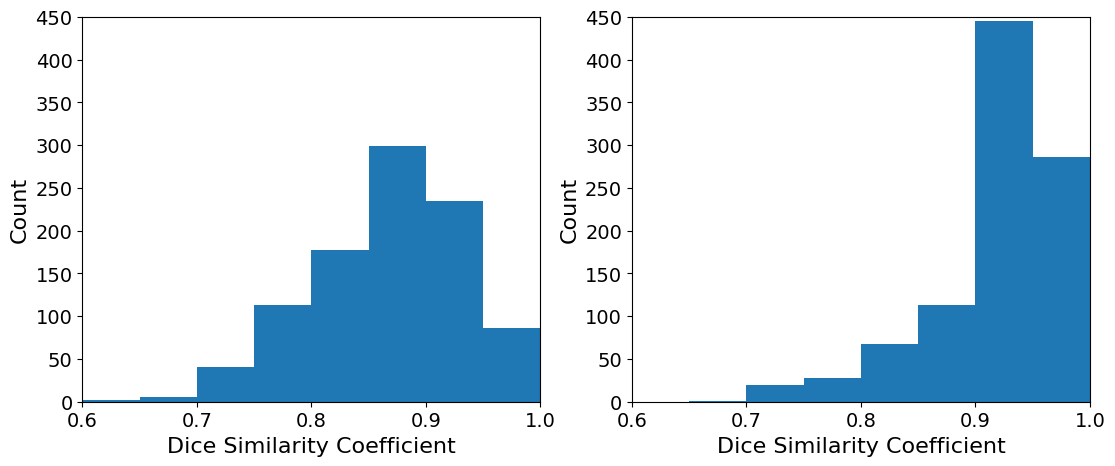

In [ ]:
bin_width = 0.05
bins = np.arange(0.60, 1.0 + bin_width, bin_width)

plt.figure(figsize=(13, 5))
plt.subplot(1, 2, 1)
plt.hist(DSCs_baseline, bins=bins)
plt.xlim(0.60, 1.0)
plt.ylim(0, 450)
plt.ylabel("Count", fontsize=16)
plt.xlabel("Dice Similarity Coefficient", fontsize=16)
plt.tick_params(axis='both', which='major', labelsize=14)
plt.subplot(1, 2, 2)
plt.hist(DSCs_unet, bins=bins)
plt.xlim(0.60, 1.0)
plt.ylim(0, 450)
plt.ylabel("Count", fontsize=16)
plt.xlabel("Dice Similarity Coefficient", fontsize=16)
plt.tick_params(axis='both', which='major', labelsize=14)
plt.show()

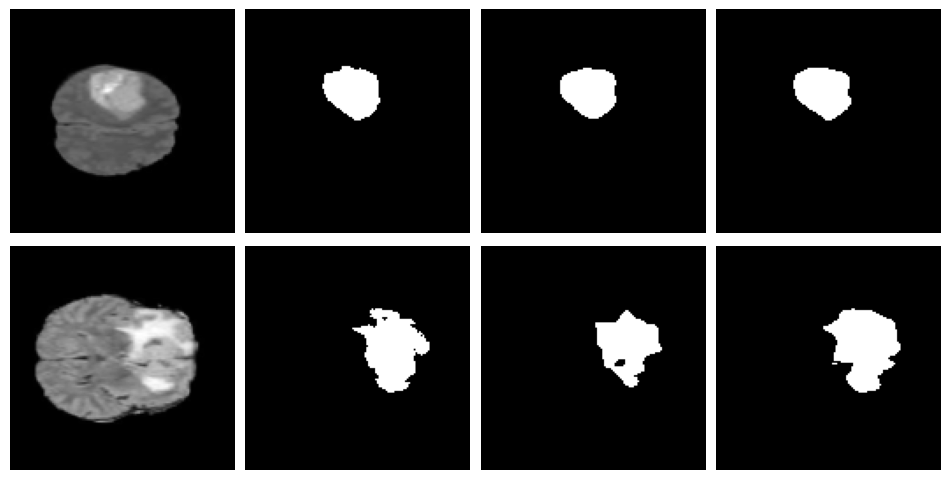

First case:
Encoder-decoder: 0.9626038781189332
U-Net: 0.9714285714305151
Second case:
Encoder-decoder: 0.8391936240112896
U-Net: 0.9046277666034355


In [ ]:
j = 0
k = 44
plt.figure(figsize=(12, 6))
plt.subplot(2, 4, 1)
plt.imshow(X_val[j, :, :], cmap='gray')
plt.axis('off')
plt.subplot(2, 4, 2)
plt.imshow(Y_val[j, :, :], cmap='gray')
plt.axis('off')
plt.subplot(2, 4, 3)
plt.imshow(Y_pred_baseline[j, :, :], cmap='gray')
plt.axis('off')
plt.subplot(2, 4, 4)
plt.imshow(Y_pred_unet[j, :, :], cmap='gray')
plt.axis('off')
plt.subplot(2, 4, 5)
plt.imshow(X_val[k, :, :], cmap='gray')
plt.axis('off')
plt.subplot(2, 4, 6)
plt.imshow(Y_val[k, :, :], cmap='gray')
plt.axis('off')
plt.subplot(2, 4, 7)
plt.imshow(Y_pred_baseline[k, :, :], cmap='gray')
plt.axis('off')
plt.subplot(2, 4, 8)
plt.imshow(Y_pred_unet[k, :, :], cmap='gray')
plt.axis('off')
plt.subplots_adjust(wspace=0.05, hspace=0.05)
plt.show()

print('First case:')
print('Encoder-decoder:', DSCs_baseline[j, 0])
print('U-Net:', DSCs_unet[j, 0])
print('Second case:')
print('Encoder-decoder:', DSCs_baseline[k, 0])
print('U-Net:', DSCs_unet[k, 0])

In [ ]:
t_stat, p_value = stats.ttest_rel(DSCs_baseline, DSCs_unet)

print(f'T-statistic: {t_stat}')
print(f'P-value: {p_value}')

T-statistic: [-30.950883]
P-value: [2.35774157e-146]


In [ ]:
Y_val = np.eye(2)[Y_val]

In [ ]:
X_fold_1 = X_train[0:940, :, :, :]
Y_fold_1 = Y_train[0:940, :, :, :]

X_fold_2 = X_train[940:940*2, :, :, :]
Y_fold_2 = Y_train[940:940*2, :, :, :]

X_fold_3 = X_train[940*2:940*3, :, :, :]
Y_fold_3 = Y_train[940*2:940*3, :, :, :]

X_fold_4 = X_train[940*3:, :, :, :]
Y_fold_4 = Y_train[940*3:, :, :, :]

X_fold_5 = X_val
Y_fold_5 = Y_val

X_folds = [X_fold_1, X_fold_2, X_fold_3, X_fold_4, X_fold_5]
Y_folds = [Y_fold_1, Y_fold_2, Y_fold_3, Y_fold_4, Y_fold_5]

del X_fold_1, X_fold_2, X_fold_3, X_fold_4, X_fold_5
del Y_fold_1, Y_fold_2, Y_fold_3, Y_fold_4, Y_fold_5

In [ ]:
main_weights_path = '/content/drive/MyDrive/Veritas AI/Veritas AI - Amaan/weights'
CV_path = os.path.join(main_weights_path, 'CV')
Path(CV_path).mkdir(exist_ok=True)
fold_list = [0, 1, 2, 3, 4]

In [ ]:
CV_baseline_path = os.path.join(CV_path, 'baseline')
Path(CV_baseline_path).mkdir(exist_ok=True)
DSCs_fold_baseline = []

for i in range(0, 5):
  # rearrange data
  CV_fold_list = fold_list[:i] + fold_list[i+1:]
  X_CV_train = X_folds[CV_fold_list[0]]
  Y_CV_train = Y_folds[CV_fold_list[0]]
  for j in range(1, 4):
    X_CV_train = np.concatenate((X_CV_train, X_folds[CV_fold_list[j]]), axis = 0)
    Y_CV_train = np.concatenate((Y_CV_train, Y_folds[CV_fold_list[j]]), axis = 0)
  X_CV_val = X_folds[i]
  Y_CV_val = Y_folds[i]
  # initialize model
  model = create_baseline_model()
  model.compile(optimizer = tf.keras.optimizers.Adam(), loss = tf.keras.losses.CategoricalCrossentropy(), metrics = [dice_accuracy])
  # checkpoint for weights
  fold_weight_path = os.path.join(CV_baseline_path, str(i))
  Path(fold_weight_path).mkdir(exist_ok=True)
  checkpoint = tf.keras.callbacks.ModelCheckpoint(
      monitor='val_dice_accuracy',
      filepath=os.path.join(fold_weight_path, '{epoch:03d}-{val_dice_accuracy:.4f}.h5'),
      verbose=0,
      save_weights_only=True,
      save_best_only=True,
      mode='max')
  # train fold
  model.fit(X_CV_train, Y_CV_train, validation_data = (X_CV_val, Y_CV_val),
            epochs = 30, batch_size = 16, callbacks=[checkpoint], verbose = 0)
  # choose best epoch
  fold_weights_list = os.listdir(fold_weight_path)
  fold_weights_list.sort()
  model.load_weights(os.path.join(fold_weight_path, fold_weights_list[-1]))
  # predict
  Y_pred = model.predict(X_CV_val, verbose = 0)
  Y_pred = np.argmax(Y_pred, axis = -1)
  # evaluate
  Y_gt = np.argmax(Y_CV_val, axis = -1)
  DSCs_fold = np.zeros((Y_CV_val.shape[0], 1))
  for j in range(0, Y_CV_val.shape[0]):
    DSCs_fold[j, 0] = get_DSC(Y_gt[j, :, :], Y_pred[j, :, :])
  # save
  DSCs_fold_baseline.append(DSCs_fold)

DSCs_baseline = [np.mean(x) for x in DSCs_fold_baseline]
print(np.mean(DSCs_baseline), np.std(DSCs_baseline))

0.875323020703773 0.020772621204636455


In [ ]:
CV_unet_path = os.path.join(CV_path, 'unet')
Path(CV_unet_path).mkdir(exist_ok=True)
DSCs_fold_unet = []

for i in range(0, 5):
  # rearrange data
  CV_fold_list = fold_list[:i] + fold_list[i+1:]
  X_CV_train = X_folds[CV_fold_list[0]]
  Y_CV_train = Y_folds[CV_fold_list[0]]
  for j in range(1, 4):
    X_CV_train = np.concatenate((X_CV_train, X_folds[CV_fold_list[j]]), axis = 0)
    Y_CV_train = np.concatenate((Y_CV_train, Y_folds[CV_fold_list[j]]), axis = 0)
  X_CV_val = X_folds[i]
  Y_CV_val = Y_folds[i]
  # initialize model
  model = create_unet_model()
  model.compile(optimizer = tf.keras.optimizers.Adam(), loss = tf.keras.losses.CategoricalCrossentropy(), metrics = [dice_accuracy])
  # checkpoint for weights
  fold_weight_path = os.path.join(CV_unet_path, str(i))
  Path(fold_weight_path).mkdir(exist_ok=True)
  checkpoint = tf.keras.callbacks.ModelCheckpoint(
      monitor='val_dice_accuracy',
      filepath=os.path.join(fold_weight_path, '{epoch:03d}-{val_dice_accuracy:.4f}.h5'),
      verbose=0,
      save_weights_only=True,
      save_best_only=True,
      mode='max')
  # train fold
  model.fit(X_CV_train, Y_CV_train, validation_data = (X_CV_val, Y_CV_val),
            epochs = 30, batch_size = 16, callbacks=[checkpoint], verbose = 0)
  # choose best epoch
  fold_weights_list = os.listdir(fold_weight_path)
  fold_weights_list.sort()
  model.load_weights(os.path.join(fold_weight_path, fold_weights_list[-1]))
  # predict
  Y_pred = model.predict(X_CV_val, verbose = 0)
  Y_pred = np.argmax(Y_pred, axis = -1)
  # evaluate
  Y_gt = np.argmax(Y_CV_val, axis = -1)
  DSCs_fold = np.zeros((Y_CV_val.shape[0], 1))
  for j in range(0, Y_CV_val.shape[0]):
    DSCs_fold[j, 0] = get_DSC(Y_gt[j, :, :], Y_pred[j, :, :])
  # save
  DSCs_fold_unet.append(DSCs_fold)

DSCs_unet = [np.mean(x) for x in DSCs_fold_unet]
print(np.mean(DSCs_unet), np.std(DSCs_unet))

0.9147627828841364 0.015334318343213423


In [ ]:
for i in range(0, 5):
  diff = DSCs_fold_unet[i] - DSCs_fold_baseline[i]
  _, p_value = stats.ttest_rel(DSCs_fold_baseline[i], DSCs_fold_unet[i])
  print(np.mean(diff), p_value)

0.03434782221168805 [7.88797279e-66]
0.04873105152383543 [8.75388867e-86]
0.03505390410642062 [7.2754312e-64]
0.03485894682951437 [1.15520657e-111]
0.04420708623035867 [2.365289e-140]
